# Analysing and Predicting Churn rate of users of 'Audiobook' app

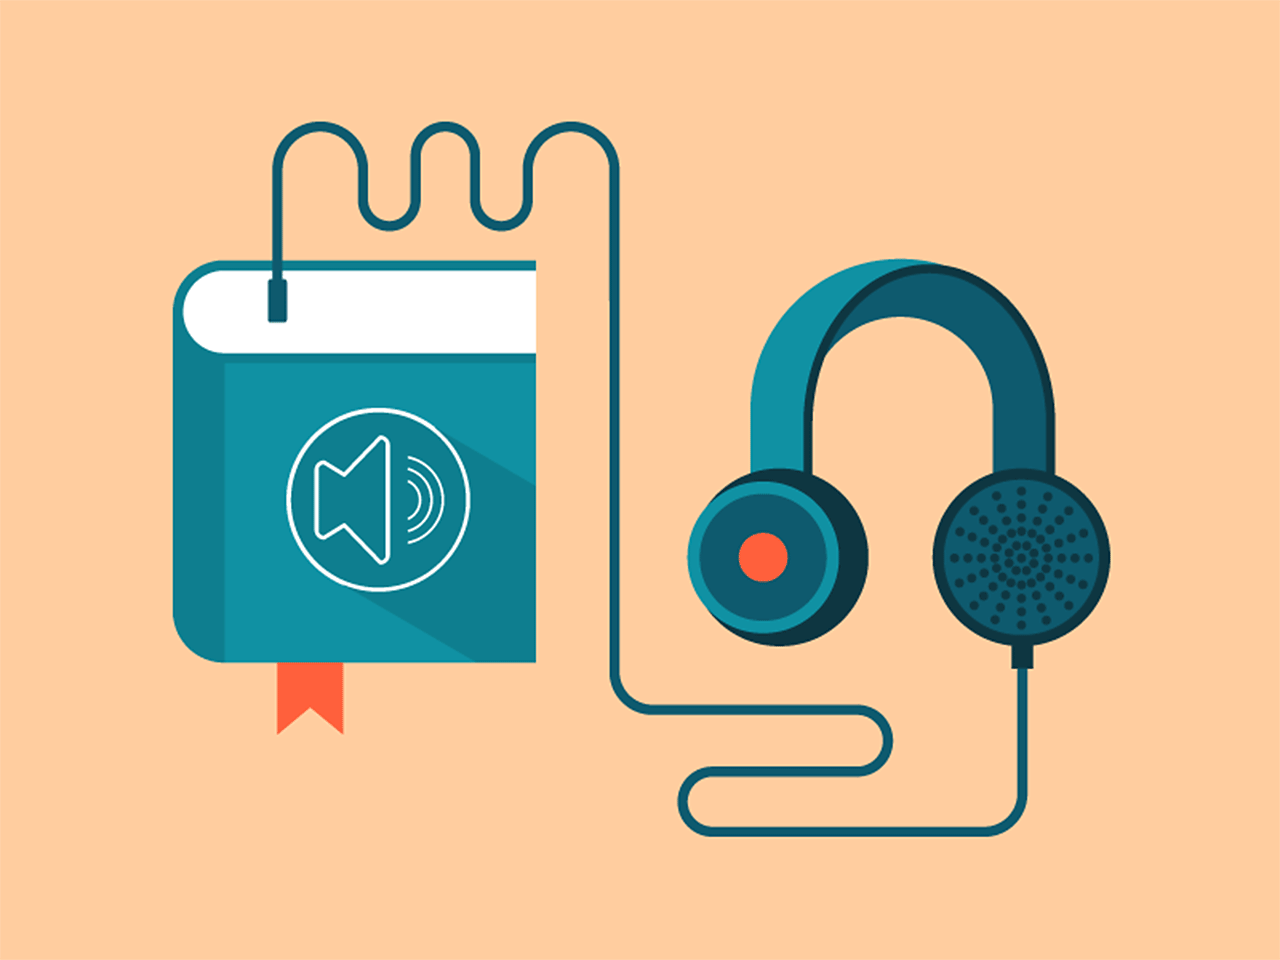

You are given data from an Audiobook app. Logically, it relates only to the audio versions of books.  We want to create a machine learning model based on our available data that can predict if a customer will buy again from the Audiobook company.

- The data is from an audiobook app, each customer in the database has make a purchase at least once.
- The main idea is that the company shouldn't spend there money targeting individuals who are unlikely to come back.
- If we focus on client who are more likely to convert again we'll get increase the sales and profitability figures.

The model must show us which are the most important metrics for a client to come back.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

plt.style.use('seaborn')

%matplotlib inline
sns.set_style("whitegrid")

pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
pd.set_option("display.float_format", "{:.2f}".format)

In [2]:
data = pd.read_csv("audiobook_data_2.csv", index_col=0)
data.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
994,1620.00,1620,19.73,19.73,1,10.00,0.99,1603.80,5,92,0
1143,2160.00,2160,5.33,5.33,0,8.91,0.00,0.00,0,0,0
2059,2160.00,2160,5.33,5.33,0,8.91,0.00,0.00,0,388,0
2882,1620.00,1620,5.96,5.96,0,8.91,0.42,680.40,1,129,0
3342,2160.00,2160,5.33,5.33,0,8.91,0.22,475.20,0,361,0


In [3]:
count = (data['Review']).value_counts()[0]
print("Number of users who didnt give reviews are : ", count, " out of 14084")

Number of users who didnt give reviews are :  11820  out of 14084


# 1. Getting aquainted with the dataset

- `ÌD`: is like a name.

- `Book_length(mins)_overall`: is the sum of the lengths of purchases.

- `Book_length(mins)_avg`: is the sum of the lengths of purchases divided by the number of purchases. Notice we don't need the number of purchases column because we ca get it from `Book_length(mins)_overall` / `Book_length(mins)_avg`.

- `Price_overall` & `Price_avg`: Same as Book length, the price variable is almost always a good predictor.

- `Review`: is boolean. It shows if the customer left a review. If so, `Review10/10` saves the review left by the user. While most users don't left a review we fill the missing reviews by avrage review column.

- `Minutes_listened`: is a measure of engagement, the total of minutes the user listen to audiobooks.

- `Completion`: is the `Minutes_listened` / `Book_length(mins)_overall`.

- `Support_Request`: Shows the total number of support request (forgotten password to assistance).

- `Last_Visited_mins_Purchase_date`: the bigger the difference, the bigger sooner the engagement. If the value is 0, we are sure the customer has never accessed what he/she has bought.

The data was gathered from the audiobook app, the input data represents `2 years` worth of engagement. We are doing supervised learning so we need `target`. We took extra `6 month` to check if the user converted or not. 1 if the customer buys in the next 6 months, 0 if the customer didn't.

- `target`: 1 if the customer bought again in the last 6 months of data. 0 if the customer did not buy again.

# 2. Exploratory Data Analysis

In [4]:
data.describe()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date,Target
count,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00,14084.00
mean,1591.28,1678.61,7.10,7.54,0.16,8.91,0.13,189.89,0.07,61.94,0.16
std,504.34,654.84,4.93,5.56,0.37,0.64,0.24,371.08,0.47,88.21,0.37
min,216.00,216.00,3.86,3.86,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,1188.00,1188.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,0.00,0.00
50%,1620.00,1620.00,5.95,6.07,0.00,8.91,0.00,0.00,0.00,11.00,0.00
75%,2160.00,2160.00,8.00,8.00,0.00,8.91,0.13,194.40,0.00,105.00,0.00
max,2160.00,7020.00,130.94,130.94,1.00,10.00,1.00,2160.00,30.00,464.00,1.00


In [5]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14084 entries, 994 to 251
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Book_length(mins)_overall        14084 non-null  float64
 1   Book_length(mins)_avg            14084 non-null  int64  
 2   Price_overall                    14084 non-null  float64
 3   Price_avg                        14084 non-null  float64
 4   Review                           14084 non-null  int64  
 5   Review10/10                      14084 non-null  float64
 6   Completion                       14084 non-null  float64
 7   Minutes_listened                 14084 non-null  float64
 8   Support_Request                  14084 non-null  int64  
 9   Last_Visited_mins_Purchase_date  14084 non-null  int64  
 10  Target                           14084 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.3 MB


In [6]:
data.isnull().sum()

Book_length(mins)_overall          0
Book_length(mins)_avg              0
Price_overall                      0
Price_avg                          0
Review                             0
Review10/10                        0
Completion                         0
Minutes_listened                   0
Support_Request                    0
Last_Visited_mins_Purchase_date    0
Target                             0
dtype: int64

## `Book_length(mins)_overall` & `Book_length(mins)_avg`

- `Book_length(mins)_overall`: is the sum of the lengths of purchases.

- `Book_length(mins)_avg`: is the sum of the lengths of purchases divided by the number of purchases. Notice we don't need the number of purchases column because we ca get it from `Book_length(mins)_overall` / `Book_length(mins)_avg`.

In [7]:
data['Book_length(mins)_overall'].value_counts()

2160.00    4712
1620.00    4149
1188.00    2851
648.00      712
1080.00     567
324.00      300
540.00      115
1404.00     112
1890.00     110
1674.00      98
1134.00      52
216.00       51
1656.00      27
1476.00      23
1350.00      21
756.00       21
918.00       15
1332.00      14
1242.00      13
864.00       13
1296.00      10
1152.00       8
1116.00       7
972.00        7
486.00        6
1377.00       5
1368.00       5
1512.00       5
1224.00       5
1044.00       4
432.00        4
594.00        4
1008.00       3
702.00        3
684.00        3
504.00        2
576.00        2
1161.00       2
1269.00       2
928.80        1
1252.80       1
1440.00       1
1339.20       1
990.00        1
378.00        1
945.00        1
828.00        1
1431.00       1
720.00        1
612.00        1
1062.00       1
1170.00       1
810.00        1
1260.00       1
1058.40       1
270.00        1
1231.20       1
999.00        1
1002.86       1
1098.00       1
Name: Book_length(mins)_overall, dtype: 

In [8]:
def book_length(length):
    if length > 1200:
        return 1
    else:
        return 0
    
data['purchases_hour_>3h'] = data['Book_length(mins)_overall'].apply(book_length)

In [9]:
data['Book_length(mins)_avg'].apply(book_length).value_counts()

1    9480
0    4604
Name: Book_length(mins)_avg, dtype: int64

In [10]:
data['purchases_hour_>3h'].value_counts()

1    9317
0    4767
Name: purchases_hour_>3h, dtype: int64

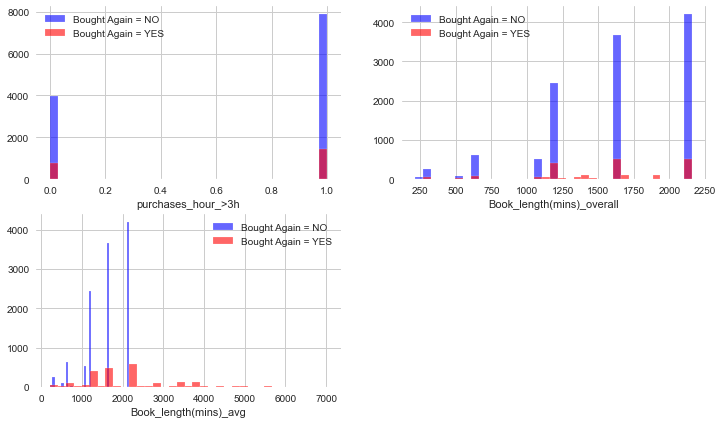

In [11]:
columns = ['purchases_hour_>3h', 'Book_length(mins)_overall', 'Book_length(mins)_avg']
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Price_overall` & `Price_avg`

- `Price_overall` & `Price_avg`: Same as Book length, the price variable is almost always a good predictor.

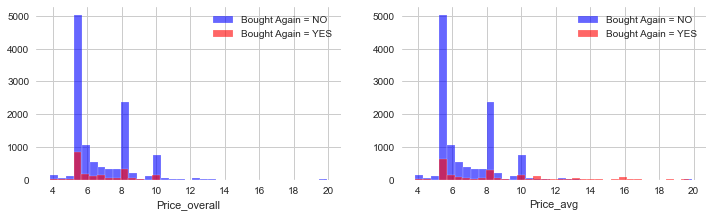

In [12]:
columns = ["Price_overall", "Price_avg"]
plt.figure(figsize=(12, 7))
df = data[(data.Price_overall < 20) & (data.Price_avg < 20)]

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    df[df["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    df[df["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Review` & `Review10/10`
- `Review`: is boolean. It shows if the customer left a review. If so, `Review10/10` saves the review left by the user. While most users don't left a review we fill the missing reviews by avrage review column.

In [13]:
print(data[data['Review'] == 0].Target.value_counts(normalize=True))
print(data[data['Review'] == 1].Target.value_counts(normalize=True))

0   0.84
1   0.16
Name: Target, dtype: float64
0   0.83
1   0.17
Name: Target, dtype: float64


In [14]:
data['Review10/10'].value_counts()

8.91     11616
10.00     1284
8.00       404
9.00       381
7.00       157
6.00       104
5.00        43
9.50        21
4.00        18
8.50        11
1.00        10
3.00         9
2.00         7
6.50         5
8.67         2
7.50         2
5.50         2
8.33         2
4.50         1
9.67         1
9.40         1
1.50         1
6.67         1
7.75         1
Name: Review10/10, dtype: int64

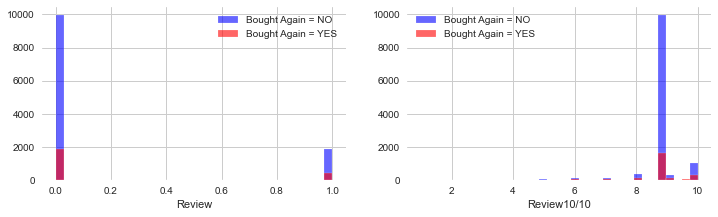

In [15]:
columns = ["Review", "Review10/10"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

## `Minutes_listened` & `Completion`
- `Minutes_listened`: is a measure of engagement, the total of minutes the user listen to audiobooks.
- `Completion`: is the `Minutes_listened` / `Book_length(mins)_overall`.

In [16]:
def listened_to_books(minutes):
    if minutes > 0.0:
        return 0
    else:
        return 1
data['listened_to_books'] = data.Minutes_listened.apply(listened_to_books)

In [17]:
def completion_state(minutes):
    if minutes > 0.5:
        return 1
    else:
        return 0
data['completion_state'] = data.Completion.apply(completion_state)

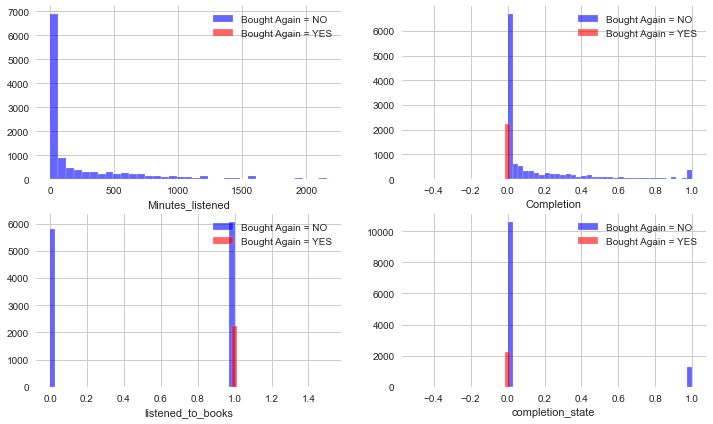

In [18]:
columns = ["Minutes_listened", "Completion", "listened_to_books", "completion_state"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)
    
    


In [19]:
data.drop('Minutes_listened', axis=1, inplace=True)

## `Support_Request` & `Last_Visited_mins_Purchase_date`

- `Support_Request`: Shows the total number of support request (forgotten password to assistance).
- `Last_Visited_mins_Purchase_date`: the bigger the difference, the bigger sooner the engagement. If the value is 0, we are sure the customer has never accessed what he/she has bought.

In [20]:
def asked_for_request(request):
    if request == 0:
        return 0
    else:
        return 1
    
data["asked_for_request"] = data.Support_Request.apply(asked_for_request)

In [21]:
def acc_purchases(purchase):
    if purchase == 0:
        return 0
    else:
        return 1
data['acc_purchases'] = data.Last_Visited_mins_Purchase_date.apply(acc_purchases)

In [22]:
data.Last_Visited_mins_Purchase_date.value_counts()

0      5493
1       357
2       198
3       165
5       140
       ... 
369       1
367       1
339       1
379       1
363       1
Name: Last_Visited_mins_Purchase_date, Length: 371, dtype: int64

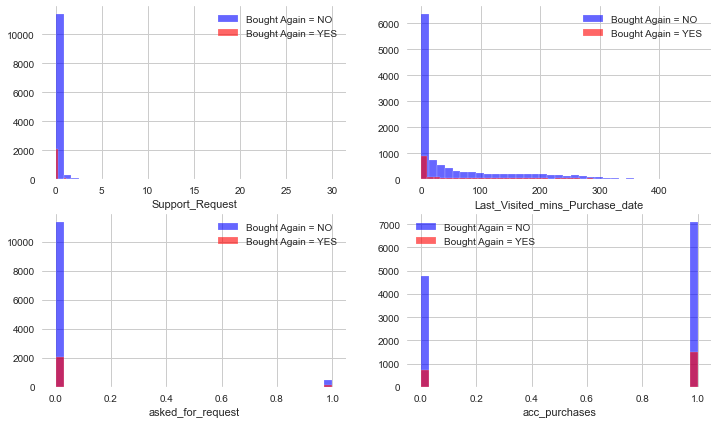

In [23]:
columns = ["Support_Request", "Last_Visited_mins_Purchase_date", "asked_for_request", "acc_purchases"]
plt.figure(figsize=(12, 7))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    data[data["Target"] == 0][column].hist(bins=35, color='blue', label='Bought Again = NO', alpha=0.6)
    data[data["Target"] == 1][column].hist(bins=35, color='red', label='Bought Again = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

In [24]:
data.drop('Support_Request', axis=1, inplace=True)

In [25]:
print(f"{data.Target.value_counts()}")
print(f"{data.Target.value_counts()[0] / data.Target.value_counts()[1]}")

0    11847
1     2237
Name: Target, dtype: int64
5.295932051855163


It is important to notice that our `target` variable is inbabalanced. We have only `2237` user who convert again in the `6 month` period. The data need to be balanced.

<AxesSubplot:>

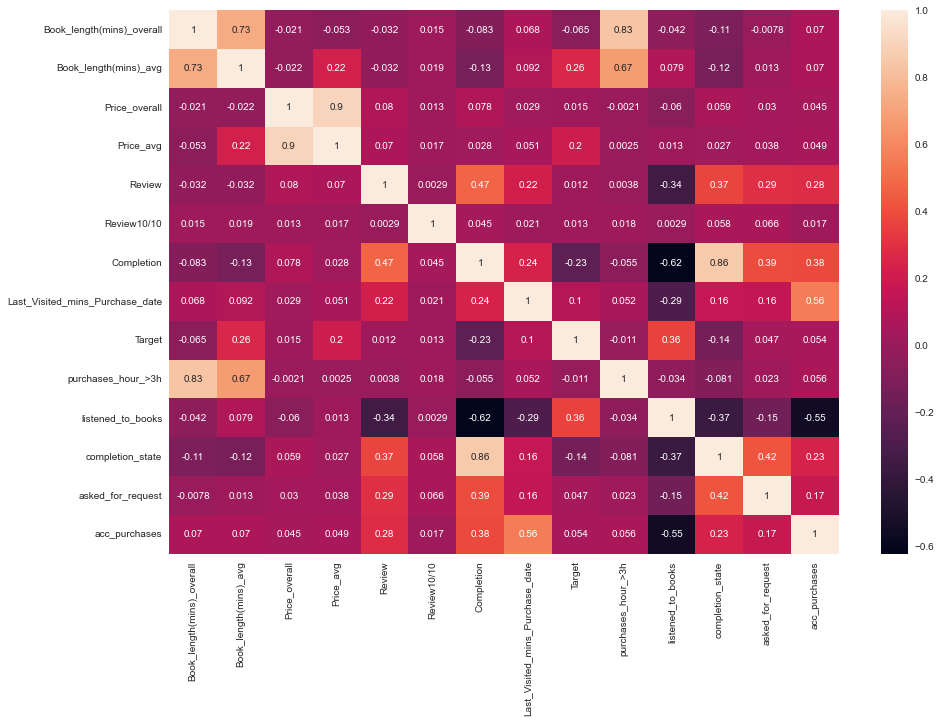

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True)

# 3. Data Pre-processing

Since we are dealing with real life data, we will need to preprocess it a bit. This is the relevant code which is not that hard but refers to data engineering more than machine learning.

- Removing Duplicates
- Standardising 
- Shuffling 
- Splitting 

### Loading data

In [27]:
r_data = pd.read_csv("audiobook_data_2.csv", index_col=0)


### Removing duplicates

In [28]:
print(f"Data shape before removing duplicates: {r_data.shape}")

# Remove duplicate Features
r_data = r_data.T.drop_duplicates()
r_data = r_data.T

# Remove Duplicate Rows
r_data.drop_duplicates(inplace=True)

print(f"Data shape after removing duplicates: {r_data.shape}")

Data shape before removing duplicates: (14084, 11)
Data shape after removing duplicates: (9350, 11)


In [29]:
X = r_data.loc[:, r_data.columns != 'Target']
y = r_data.loc[:, r_data.columns == 'Target']

#ON SHUFFLING --> shuffled_inputs = scaled_inputs[shuffled_indices]
#                 shuffled_targets = y[shuffled_indices]

#following error was coming
#         # take() does not accept boolean indexers
# KeyError: "None of [Int64Index([8346, 1990, 1572, 7182, 4024, 7023, 2579, 3347, 6357, 3399,\n            ...\n            6354, 2956, 2961, 2840, 9204, 6510, 1736, 6907, 2988, 2011],\n           dtype='int64', length=9350)] are in the [columns]"

# Because Y is still a dataframe, convert it into numpy array

#y = y.to_numpy()

y = y.to_numpy() #converting y dataframe to numpy array
raw_csv_data = np.loadtxt('audiobook_data_2.csv', delimiter = ',', skiprows=1)

unscaled_inputs_all = raw_csv_data[:,1:-1]

targets_all = raw_csv_data[:,-1]
raw_csv_data

array([[9.9400e+02, 1.6200e+03, 1.6200e+03, ..., 5.0000e+00, 9.2000e+01,
        0.0000e+00],
       [1.1430e+03, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0590e+03, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 3.8800e+02,
        0.0000e+00],
       ...,
       [3.1134e+04, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2832e+04, 1.6200e+03, 1.6200e+03, ..., 0.0000e+00, 9.0000e+01,
        0.0000e+00],
       [2.5100e+02, 1.6740e+03, 3.3480e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [30]:
X.shape

(9350, 10)

In [31]:
y.shape

(9350, 1)

### Standardization

In [32]:
X.head()

,Book_length(mins)_overall,Book_length(mins)_avg,Price_overall,Price_avg,Review,Review10/10,Completion,Minutes_listened,Support_Request,Last_Visited_mins_Purchase_date
994,1620.00,1620.00,19.73,19.73,1.00,10.00,0.99,1603.80,5.00,92.00
1143,2160.00,2160.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,0.00
2059,2160.00,2160.00,5.33,5.33,0.00,8.91,0.00,0.00,0.00,388.00
2882,1620.00,1620.00,5.96,5.96,0.00,8.91,0.42,680.40,1.00,129.00
3342,2160.00,2160.00,5.33,5.33,0.00,8.91,0.22,475.20,0.00,361.00


In [33]:
X = preprocessing.scale(X)
X

array([[ 8.22962973e-02, -1.10932123e-01,  2.16510348e+00, ...,
         3.10925764e+00,  8.49379342e+00,  6.24000665e-03],
       [ 1.15445564e+00,  6.58059089e-01, -3.80980509e-01, ...,
        -6.68905568e-01, -1.83570326e-01, -9.70229653e-01],
       [ 1.15445564e+00,  6.58059089e-01, -3.80980509e-01, ...,
        -6.68905568e-01, -1.83570326e-01,  3.14792500e+00],
       ...,
       [ 8.22962973e-02, -1.10932123e-01, -3.80980509e-01, ...,
         1.65905358e+00, -1.83570326e-01, -9.27774450e-01],
       [-9.89863045e-01, -8.79923334e-01, -1.65270616e-01, ...,
         6.89175500e-02, -1.83570326e-01, -6.62429434e-01],
       [ 8.22962973e-02, -1.10932123e-01, -3.80980509e-01, ...,
         7.81298491e-01, -1.83570326e-01, -1.49875946e-02]])

### Shuffling the data

In [34]:
shuffled_indices = np.arange(X.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = X[shuffled_indices]
shuffled_targets = y[shuffled_indices]

### Splitting Train, Test

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(6545, 10)
(2805, 10)
(6545, 1)


In [36]:
y_train = y_train.flatten()

In [37]:
print(y_train[5])

1.0


In [38]:

y_train.shape
sum1 = 0
sum0 = 0
for i in range(y_train.shape[0]):
    if(y_train[i]==1):
        sum1+=1
    else:
        sum0+=1

zeros = (sum0 / y_train.shape[0])
ones = (sum1 / y_train.shape[0])
print(sum1)
print(sum0)
print(f"Doesn't purchase again users Rate: {zeros * 100:.2f}%")
print(f"Purchase again users Rate: {ones * 100 :.2f}%")

1264
5281
Doesn't purchase again users Rate: 80.69%
Purchase again users Rate: 19.31%


### Current churn rate is 80.69%

# 4. Model Building

## 4. 1. Logistic Regression 

In [39]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
logreg

LogisticRegression()

In [41]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on training set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.8987
Accuracy of logistic regression classifier on test set: 0.8930


### Accuracy of Logistic regression is 89.30%

### [ Optimising using GridSearchCV ]

In [42]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,5,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, cv= 5, verbose = 2, return_train_score=True)
logreg.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, sol

C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   1.8s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   1.8s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   1.8s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...............C=10.0, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END ...............C=10.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...............C=10.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10.0, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=10

C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=215.44346900318823, penalty=l1, solver=liblinear; total time=   2.6s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=215.44346900318823, penalty=l1, solver=liblinear; total time=   2.0s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=215.44346900318823, penalty=l1, solver=liblinear; total time=   2.1s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=215.44346900318823, penalty=l1, solver=liblinear; total time=   2.9s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .C=215.44346900318823, penalty=l1, solver=liblinear; total time=   2.5s
[CV] END .C=215.44346900318823, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=newton-cg; total time=   0.0s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=215.44346900318823, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=215.44346900318823, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=215.44346900318823, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=215.44346900318823, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=215.44346900318823, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=215.44346900318823, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=4641.588833612773, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=4641.588833612773, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ..C=4641.5888336127

C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=4641.588833612773, penalty=l1, solver=liblinear; total time=   2.4s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=4641.588833612773, penalty=l1, solver=liblinear; total time=   2.3s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=4641.588833612773, penalty=l1, solver=liblinear; total time=   2.5s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=4641.588833612773, penalty=l1, solver=liblinear; total time=   1.0s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..C=4641.588833612773, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END ..C=4641.588833612773, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=4641.588833612773, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ..C=4641.588833612773, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=4641.588833612773, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..C=4641.588833612773, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ......C=4641.588833612773, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=4641.588833612773, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=4641.588833612773, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=4641.588833612773, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......C=4641.588833612773, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..C=4641.588833612773, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=4641.5888336127

C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...........C=100000.0, penalty=l1, solver=liblinear; total time=   3.0s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...........C=100000.0, penalty=l1, solver=liblinear; total time=   2.2s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...........C=100000.0, penalty=l1, solver=liblinear; total time=   3.0s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...........C=100000.0, penalty=l1, solver=liblinear; total time=   1.2s


C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...........C=100000.0, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END ...........C=100000.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...........C=100000.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...........C=100000.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...........C=100000.0, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ...........C=100000.0, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ...............C=100000.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=100000.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=100000.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=100000.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=100000.0, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...........C=100000.0, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...........C=100000

C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ashwi\anaconda3\envs\py3-TF2.0\lib\site-packages\sklearn\linear_model\_logist

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 2.15443469e-02, 4.64158883e-01, 1.00000000e+01,
       2.15443469e+02, 4.64158883e+03, 1.00000000e+05]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True, verbose=2)

In [43]:
logreg.best_score_

0.8985485103132163

#### Accuracy improved

In [44]:
logreg.best_estimator_

LogisticRegression(C=215.44346900318823, penalty='l1', solver='liblinear')

In [45]:
reg = LogisticRegression(C=10.0, solver='newton-cg')

In [46]:
reg.fit(X_train, y_train)
y_reg = reg.predict(X_test)
print('Accuracy of logistic regression classifier on training set: {:.4f}'.format(reg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(reg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.8985
Accuracy of logistic regression classifier on test set: 0.8945


In [47]:
reg.intercept_

array([-21.54369863])

In [48]:
coeff= reg.coef_
coeff

array([[ -2.22190009,   3.11598385,  -2.15035822,   2.52903338,
          0.79908503,   0.19053507, -16.19211208, -16.8750008 ,
          2.10115652,   0.27764135]])

In [49]:
y_pred = logreg.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(logreg.score(X_train, y_train)*100))
print('Accuracy of Support Vector Machine classifier on test set: {:.4f}'.format(logreg.score(X_test, y_test)*100))

Accuracy of classifier on training set: 89.8701
Accuracy of Support Vector Machine classifier on test set: 89.4474


In [50]:
input_columns = r_data.loc[:, r_data.columns != 'Target']
feature_names = input_columns.columns.values

In [51]:
summary = pd.DataFrame(columns=['Feature name'], data= feature_names)
summary['Coefficient' ]= np.transpose(coeff)
summary

,Feature name,Coefficient
0,Book_length(mins)_overall,-2.22
1,Book_length(mins)_avg,3.12
2,Price_overall,-2.15
3,Price_avg,2.53
4,Review,0.80
5,Review10/10,0.19
6,Completion,-16.19
7,Minutes_listened,-16.88
8,Support_Request,2.10
9,Last_Visited_mins_Purchase_date,0.28


In [52]:
summary['Magnitude'] = summary['Coefficient'].abs()
summary.sort_values('Magnitude', ascending=False)

,Feature name,Coefficient,Magnitude
7,Minutes_listened,-16.88,16.88
6,Completion,-16.19,16.19
1,Book_length(mins)_avg,3.12,3.12
3,Price_avg,2.53,2.53
0,Book_length(mins)_overall,-2.22,2.22
2,Price_overall,-2.15,2.15
8,Support_Request,2.10,2.10
4,Review,0.80,0.80
9,Last_Visited_mins_Purchase_date,0.28,0.28
5,Review10/10,0.19,0.19


## This shows that 'Minutes_listened' and 'Completion' plays highest role in prediction.

### Probabilities of output(1) of each entry

In [53]:
predict_probability = logreg.predict_proba(X_test)


In [54]:
predict_probability[:,1]

array([0.42742186, 0.80172086, 0.34681505, ..., 0.34425326, 0.32009591,
       0.99999992])

In [55]:
logregProb = pd.DataFrame()


In [56]:
logregProb['Probability of getting output 1'] = predict_probability[:,1]
logregProb.head(20)

,Probability of getting output 1
0,0.43
1,0.80
2,0.35
3,0.26
4,0.00
5,1.00
6,0.00
7,0.31
8,0.00
9,0.00


## Confusion matrix

In [57]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2255   12]
 [ 284  254]]


<AxesSubplot:>

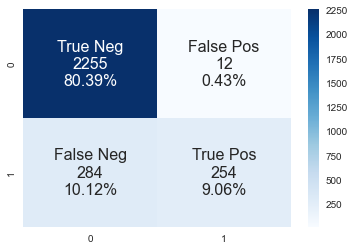

In [58]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      2267
         1.0       0.95      0.47      0.63       538

    accuracy                           0.89      2805
   macro avg       0.92      0.73      0.79      2805
weighted avg       0.90      0.89      0.88      2805



#### The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

#### The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

#### The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
#### The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

#### The support is the number of occurrences of each class in y_test.

## 4. 2 Decision tree

In [60]:
from sklearn.tree import DecisionTreeClassifier
DTclf_model = DecisionTreeClassifier(criterion="gini", random_state=1,max_depth=5, min_samples_leaf=1)   
DTclf_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [61]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.9060
Accuracy of Decision tree classifier on test set: 0.8991


### Accuracy of Decision tree classification is 89.91%

### [ Optimising using GridSearchCV ]

In [62]:
parameters = {'max_leaf_nodes': [3, 7, 10, 30, 40], 
          'min_samples_split': [4, 6, 8, 10],
          'max_depth':[4,5,6,7,8,10,13,15,20]}

DTclf_model = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv= 5, verbose = 2, return_train_score = True)
DTclf_model.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=4, max_leaf_nodes=3, min_s

[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=5, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_le

[CV] END .max_depth=6, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=3, min_samples_split=8; total time=   0.0s
[CV] END max_depth=6, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=6, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=6, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=6, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=6, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=6, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=6, max_l

[CV] END max_depth=7, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_leaf_nodes=3, min_samples_split=10; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=7, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=7, max_l

[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=4; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=8, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END .max_depth=8, max_l

[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, max

[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=6; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=8; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=7, min_samples_split=10; total time=   0.0s
[CV] END max_depth=13, max_leaf_nodes=10, min_samples_split=4; total time=   0.0s
[CV] END max_depth=13,

[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=6; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=8; total time=   0.0s
[CV] END max_dep

[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=30, min_samples_split=4; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=30, min_samples_split=4; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=30, min_samples_split=4; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=30, min_samples_split=4; total time=   0.0s
[CV] END max_depth=20, max_leaf_nodes=30, min_samples_split=4; total time=   0.0s
[CV] END ma

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 10, 13, 15, 20],
                         'max_leaf_nodes': [3, 7, 10, 30, 40],
                         'min_samples_split': [4, 6, 8, 10]},
             return_train_score=True, verbose=2)

In [63]:
# Mean training score
np.average(DTclf_model.cv_results_['mean_train_score'])

0.9005733808674986

In [64]:
#Mean testing score
DTclf_model.best_score_

0.9101604278074866

#### Accuracy improved from 89.91% to 91.01%

In [65]:
DTclf_model.best_params_

{'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_split': 8}

In [66]:
y_predDT = DTclf_model.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(DTclf_model.score(X_train, y_train)))
print('Accuracy of Decision tree classifier on test set: {:.4f}'.format(DTclf_model.score(X_test, y_test)))

Accuracy of classifier on training set: 0.9144
Accuracy of Decision tree classifier on test set: 0.9055


### Confusion matrix

In [67]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predDT)
print(confusion_matrix)

[[2266    1]
 [ 264  274]]


<AxesSubplot:>

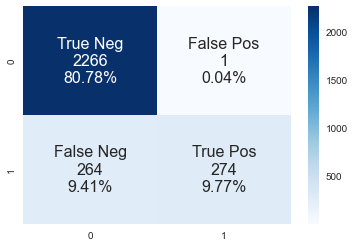

In [68]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predDT))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2267
         1.0       1.00      0.51      0.67       538

    accuracy                           0.91      2805
   macro avg       0.95      0.75      0.81      2805
weighted avg       0.91      0.91      0.89      2805



## 4.3 XG Boost 

In [70]:


from xgboost import XGBClassifier
xgb_clf = XGBClassifier(learning_rate=0.5, n_estimators=150, base_score=0.5)
xgb_clf.fit(X_train, y_train)
y_predXG = xgb_clf.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(xgb_clf.score(X_train, y_train)))
print('Accuracy of Extreme Gradient Boosting classifier on test set: {:.4f}'.format(xgb_clf.score(X_test, y_test)))


Accuracy of classifier on training set: 0.9662
Accuracy of Extreme Gradient Boosting classifier on test set: 0.8799


### [ Optimising using GridSearchCV ]

In [71]:
param_grid = { 
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

xgb_clf = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv= 5, verbose = 2, n_jobs = 10, return_train_score=True)
xgb_clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [72]:
xgb_clf.best_score_

0.9124522536287243

In [73]:
xgb_clf.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}

In [74]:
y_predXG = xgb_clf.predict(X_test)
print('Accuracy of classifier on training set: {:.4f}'.format(xgb_clf.score(X_train, y_train)*100))
print('Accuracy of XGBoost classifier on test set: {:.4f}'.format(xgb_clf.score(X_test, y_test)*100))

Accuracy of classifier on training set: 91.6119
Accuracy of XGBoost classifier on test set: 90.5882


In [75]:
XGPredict = xgb_clf.predict_proba(X_test)
XGPredict

array([[0.58829236, 0.41170767],
       [0.202119  , 0.797881  ],
       [0.5834    , 0.41660002],
       ...,
       [0.5137842 , 0.48621577],
       [0.60614127, 0.39385873],
       [0.23120564, 0.76879436]], dtype=float32)

In [76]:
Prob_XGB = pd.DataFrame()
Prob_XGB['Probability of getting 1'] = XGPredict[:,1]
Prob_XGB.head(20)

,Probability of getting 1
0,0.41
1,0.80
2,0.42
3,0.31
4,0.18
5,0.81
6,0.18
7,0.41
8,0.18
9,0.18


### Confusion matrix

In [77]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predXG)
print(confusion_matrix)

[[2261    6]
 [ 258  280]]


<AxesSubplot:>

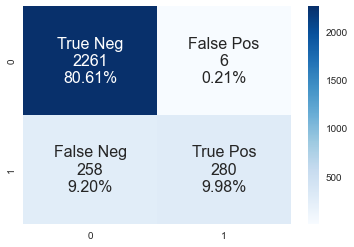

In [78]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":16})


In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predXG))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2267
         1.0       0.98      0.52      0.68       538

    accuracy                           0.91      2805
   macro avg       0.94      0.76      0.81      2805
weighted avg       0.91      0.91      0.89      2805



## 4.4 Neural network

In [80]:
scaled_inputs = X
outputs = y

#### Shuffling

In [81]:
scaled_inputs.shape[0]
outputs.shape[0]

9350

### Train, Test, Validation

In [82]:
samples_count = shuffled_inputs.shape[0]

# Count the samples in each subset, assuming we want 80-10-10 distribution of training, validation, and test.
# Naturally, the numbers are integers.
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

# The 'test' dataset contains all remaining data.
test_samples_count = samples_count - train_samples_count - validation_samples_count

# Create variables that record the inputs and targets for training
# In our shuffled dataset, they are the first "train_samples_count" observations
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

# Create variables that record the inputs and targets for validation.
# They are the next "validation_samples_count" observations, folllowing the "train_samples_count" we already assigned
validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

# Create variables that record the inputs and targets for test.
# They are everything that is remaining.
test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]

# Print the number of targets that are 1s, the total number of samples, and the proportion for training, validation, and test.
print(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count)
print(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count)
print(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

1459.0 7480 0.1950534759358289
176.0 935 0.18823529411764706
167.0 935 0.1786096256684492


In [83]:
# Set the input and output sizes
input_size = 10
output_size = 2

hidden_layer_size = 50
    

model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), 
    tf.keras.layers.Dense(output_size, activation='softmax') 
])


### Choose the optimizer and the loss function

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training

batch_size = 100

# set a maximum number of training epochs
max_epochs = 100
# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
history = model.fit(train_inputs, 
          train_targets, 
          batch_size=batch_size, 
          epochs=max_epochs, 
          # callbacks are functions to check if val_loss is increasing
          callbacks=[early_stopping], 
          validation_data=(validation_inputs, validation_targets),
          verbose = 2
          )  

Epoch 1/100
75/75 - 1s - loss: 0.3805 - accuracy: 0.8496 - val_loss: 0.2851 - val_accuracy: 0.8834 - 925ms/epoch - 12ms/step
Epoch 2/100
75/75 - 0s - loss: 0.2613 - accuracy: 0.8904 - val_loss: 0.2322 - val_accuracy: 0.8995 - 132ms/epoch - 2ms/step
Epoch 3/100
75/75 - 0s - loss: 0.2372 - accuracy: 0.8959 - val_loss: 0.2196 - val_accuracy: 0.9037 - 145ms/epoch - 2ms/step
Epoch 4/100
75/75 - 0s - loss: 0.2280 - accuracy: 0.8992 - val_loss: 0.2143 - val_accuracy: 0.9016 - 137ms/epoch - 2ms/step
Epoch 5/100
75/75 - 0s - loss: 0.2175 - accuracy: 0.9021 - val_loss: 0.2061 - val_accuracy: 0.9091 - 137ms/epoch - 2ms/step
Epoch 6/100
75/75 - 0s - loss: 0.2169 - accuracy: 0.9028 - val_loss: 0.2207 - val_accuracy: 0.9048 - 123ms/epoch - 2ms/step
Epoch 7/100
75/75 - 0s - loss: 0.2141 - accuracy: 0.9029 - val_loss: 0.2017 - val_accuracy: 0.9102 - 125ms/epoch - 2ms/step
Epoch 8/100
75/75 - 0s - loss: 0.2090 - accuracy: 0.9027 - val_loss: 0.1983 - val_accuracy: 0.9070 - 133ms/epoch - 2ms/step
Epoch 9

In [84]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

30/30 [==============================] - 0s 1ms/step - loss: 0.1963 - accuracy: 0.9166


### Accuracy of Neural Network is 91.66%

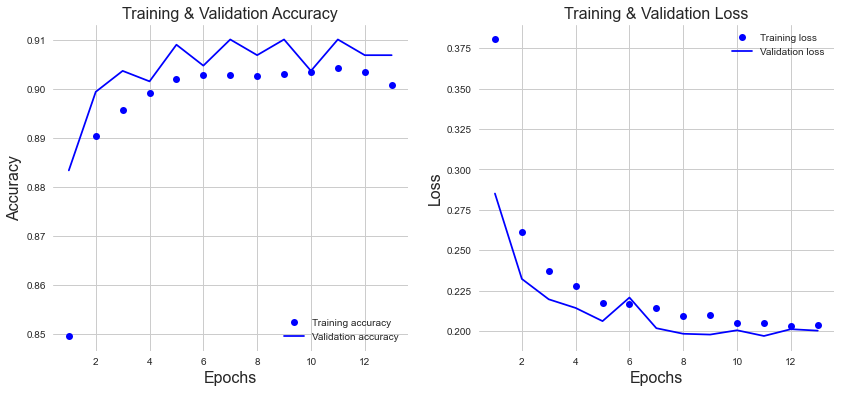

In [85]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

## Comparing Machine Learning Models

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


ml_models = {
    'Logistic Regression': logreg, 
    'XGboost': xgb_clf,
    'Decision Tree':DTclf_model
 #   'KNN': knn_clf,
 #   'SVM': svm_clf
}

LOGISTIC REGRESSION ACCURACY: 89.447
XGBOOST ACCURACY: 90.588
DECISION TREE ACCURACY: 90.553


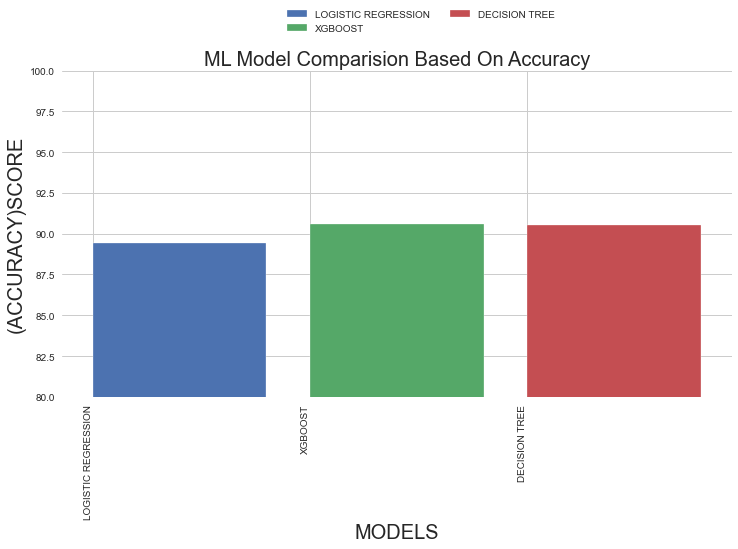

In [87]:
plt.figure(figsize=(12,6))

for model in ml_models:
    print(f"{model.upper()} ACCURACY: {ml_models[model].score(X_test,y_test)*100:.3f}")
    plt.bar(model.upper(),ml_models[model].score(X_test,y_test)*100,label=model.upper(),align="edge")
plt.title("ML Model Comparision Based On Accuracy",fontsize=20)
plt.xlabel("MODELS",fontsize=20)
plt.xticks(rotation=90,ha='right')
plt.ylim([80, 100])
plt.ylabel("(ACCURACY)SCORE",fontsize=20)
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2,loc ="right")
plt.show()


LOGISTIC REGRESSION roc_auc_score: 0.733
XGBOOST roc_auc_score: 0.759
DECISION TREE roc_auc_score: 0.754


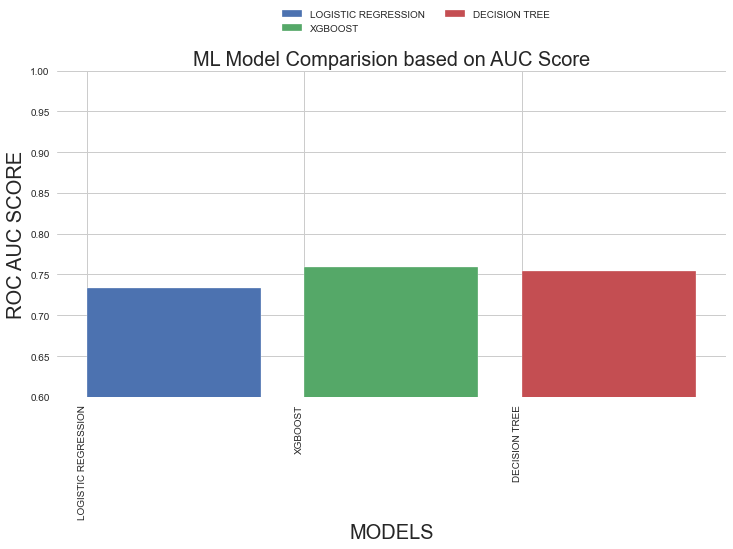

In [88]:
plt.figure(figsize=(12,6))

for model in ml_models:
    print(f"{model.upper()} roc_auc_score: {roc_auc_score(y_test, ml_models[model].predict(X_test)):.3f}")
    plt.bar(model.upper(),roc_auc_score(y_test, ml_models[model].predict(X_test)),label=model.upper(),align="edge")
plt.title("ML Model Comparision based on AUC Score",fontsize=20)
plt.xlabel("MODELS",fontsize=20)
plt.xticks(rotation=90,ha='right')
plt.ylim([0.6, 1])
plt.ylabel("ROC AUC SCORE",fontsize=20)
plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2,loc ="right")
plt.show()


## ROC Curve (Receiver Operating Characteristic Curve)

In [89]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

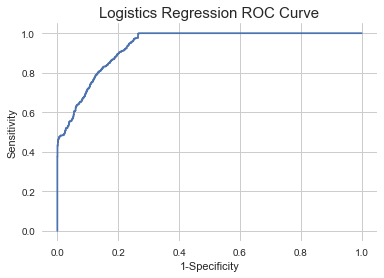

In [90]:
#Logisitic Regression
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.title("Logistics Regression ROC Curve",fontsize=15)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

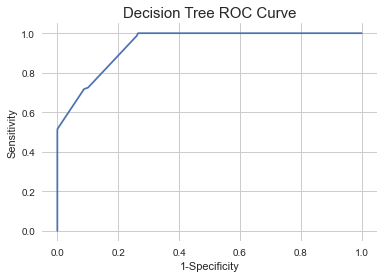

In [91]:
#Decision Tree
y_pred_proba = DTclf_model.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.title("Decision Tree ROC Curve",fontsize=15)

plt.plot(fpr1,tpr1)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

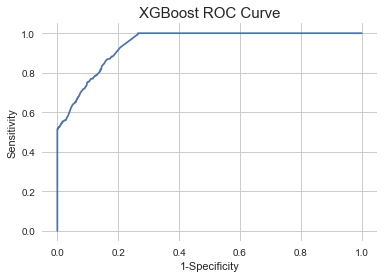

In [92]:
#XGBOOST
y_pred_proba = xgb_clf.predict_proba(X_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.title("XGBoost ROC Curve",fontsize=15)
plt.plot(fpr2,tpr2)
plt.ylabel('Sensitivity')  #True Positive Rate
plt.xlabel('1-Specificity')  #False Positive Rate
plt.show()

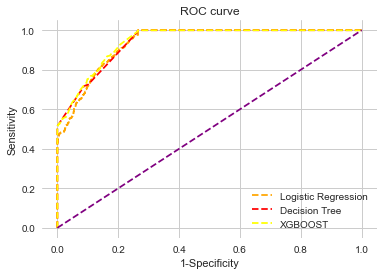

In [93]:
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Decision Tree')
plt.plot(fpr2, tpr2, linestyle='--',color='yellow', label='XGBOOST')
#plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='Random Forest')

plt.plot(p_fpr, p_tpr, linestyle='--', color='purple')
plt.title('ROC curve') #Receiver Operating Characteristic Curve
plt.xlabel('1-Specificity') #False Positive Rate
plt.ylabel('Sensitivity')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();